# 基于tushare及pyalgotrade实现A股配对交易策略
## 配对交易介绍
    - 模型原理
        - 资产定价（Asset Pricing）方式可以分为绝对定价（Absolute Pricing）和相对定价（Relative Pricing）两种方式。绝对价格方法复杂，有较大误差。相对定价基于资产的内在联系为定价基础。可以认为有内在联系的股票在价格走势上也具有一致性。  
        - 配对交易的理论基础是：相关性较高的证券的相对价值相对稳定。相关性较高的股票对的价格走势倾向于一致，所以当股票对之间的价格差变化出现异常时，配对交易策略认为该异常在未来会消失，回归到平稳的状态。
        - 配对的股价的价格走势相对一致，在大部分时间，这些股票的价格差是相对不变的，即$\Delta$price = price A - price B $\approx$ 常量。数学上这样的时间序列被称为平稳的随机过程，这里继续探讨需要讨论随机游走，OU过程的概念，这里不在展开讨论。这里继续讨论模型的适用范围和具体操作。
    - 适用范围
        - 适用于震荡市场，获取alpha绝对收益。
        - 最股票被看空的时候，需要做空（不太适合A股，可以做美国的A股指数）。
    - 股票标的选择
        - 行业划分：例如（川投能源，国投电力）和（南方航空，东方航空）
        - 价格走势相关
        - 协整检验：ADF检验和Hurst Exponent检验
        - 交易适合性：
            - 能做到价差回到均值的速度足够快。
            - 股票最好能做到交替走强。
    - 策略模式
        - 选取两个阈值， δ为买入阈值， Ω为卖出阈值
        - 并且设定一个持仓期限T，持仓时间超过T则强行平仓
        - 关于阈值的选择，可以是一个绝对值δ，也可以价差历史数据标准差的δ倍，一般选择后者，具有时变特性，对数据适应情况较好；
        - δ越大，模型发出的交易信号就越少，配对交易的次数也就越少；
        - 配对交易的亏损有两个原因：价差剧变，绝对值突破 Ω或者价差在 T个交易日内仍未回归均值被强行平仓。配对交易亏损的次数不会因为δ的设置而发生太大改变，而与此同时，高阀值将错过低阀值情况下可能成功的配对交易机会，因此最终的结果是阀值越大，配对交易的成功率，即正收益比率也就越小；
            - 阈值设置的越大，价差回归均值后配对交易的收益也就越高，但由于成功率同时大幅降低，因而总体的平均收益率随阀值的增大而减少。
## Tushare数据平台
    Tushare是一个免费、开源的python财经数据接口包。创始人米哥是国内最早一批量化投资开源项目发起者和推动者。Tushare也是目前国内唯一的python数据平台。本文使用的股票的日线数据都是从tushare上获取的。具体的使用方法和方式见：https://tushare.pro/
## Pyalgotrade回测框架
    股票量化交易的策略回测框架。事件驱动的回测框架，支持虚盘和实盘两种交易。文档完整，整合了TA-Lib(技术分析库)。非常的灵活和快速。相关的网站为http://gbeced.github.io/pyalgotrade/
## 模型的实现
    以下详细介绍模型的实现过程和结果分析，希望对于大家有很好的帮助。
    首先使用tushare获取数据，并选择停牌天数大于总交易天数的80%的股票，并存入total_df中。
    取start_date = '20170214'，end_date = '20180214'
    股票选择为半导体行业的板块。股票的列表：
        code_list  = ['002079', '002119', '002129', '002156', '002185', '002218', '002449', '002638', '002654', '002724', '002745', '002815', '002913', '300046', '300053', '300077', '300080', '300102', '300111', '300118', '300223', '300232', '300236', '300241', '300269', '300296', '300301', '300303', '300317', '300323', '300327', '300373', '300389', '300582', '300613', '300623', '300625', '300632', '300671', '300672', '300708', '600151', '600171', '600360', '600460', '600206', '600537', '600584', '600667', '600703', '601012', '603005', '603501', '603986', '300749']

In [ ]:
def select_code(code_list, start_date, end_date):
    #获取从start_date到end_date之间的交易日期
    date_arrays = list()
    for mdate in get_dates_array(start_date, end_date, dformat = "%Y%m%d"):
        if CCalendar.is_trading_day(transfer_int_to_date_string(mdate), redis = mredis):
            date_arrays.append(mdate)
    #选择股票的停牌天数小于总交易天数的80%
    total_df = pd.DataFrame()
    for code in code_list:
        df = ts.pro_bar(pro_api = ts_client, ts_code = add_suffix(code), adj = 'qfq', start_date = start_date, end_date = end_date)
        if df is None: continue
        if len(df) > int(0.8 * len(date_arrays)):
            df = df.rename(columns = {"ts_code": "code", "trade_date": "date", "pct_change": "pchange"})
            df = df.set_index('date')
            total_df[code] = df.close
    return total_df

In [10]:
获取所有半导体行业的股票数据的结果：

          002079  002119  002156  002185  002218  002449  002724  002815  \
date                                                                       
20180214    6.52   17.28    9.80    7.12    4.00   17.53    7.48   27.64   
20180213    6.64   17.35    9.65    7.14    4.01   17.75    7.43   28.21   
20180212    6.74   17.72    9.64    7.07    4.04   17.86    7.47   28.15   
20180209    6.55   17.03    9.08    6.72    3.92   16.95    7.25   25.59   
20180208    6.64   17.78    9.38    6.91    4.02   16.61    7.55   26.20   

          300046  300053   ...    300632  600171  600360  600206  600537  \
date                       ...                                             
20180214   14.51   12.38   ...     17.46   11.94    6.20    8.91    4.33   
20180213   14.86   12.42   ...     17.47   11.94    6.18    9.06    4.38   
20180212   15.20   12.60   ...     17.59   12.14    6.22    9.12    4.52   
20180209   14.73   12.11   ...     16.88   11.49    5.99    8.84    4.11   
20180208   

从tushare获得数据结构，生成dataframe，接下来选择满足协整关系的股票。
对选出来的股票对，进行两两对比：
    首先对进行最小二乘的拟合，得到最优的斜率beta。
    使用Augumented Dickey-Fuller Test方法来对进行协整关系的验证。选出来的股票对中，选取标准差最大的股票对。

In [ ]:
def compute_cointegration_pairs(df):
    rank      = dict()
    visited   = list()
    code_list = df.columns.tolist()
    for code_i in code_list:
        for code_j in code_list:
            if code_j != code_i and code_j not in visited:
                tmp_df = pd.concat([df[code_i], df[code_j]], axis = 1, sort = False)
                tmp_df = tmp_df.dropna()
                if len(tmp_df) > 0:
                    results = sm.OLS(tmp_df[code_j], tmp_df[code_i]).fit()
                    beta    = results.params.tolist()
                    spread  = tmp_df[code_j] - beta * tmp_df[code_i]
                    spread  = spread.dropna()
                    sta     = sts.adfuller(spread)
                    if sta[0] < sta[4]['1%'] and sta[1] < 0.001:
                        print(code_i, code_j, beta, sta)
                        rank[code_i + '_' + code_j] = (np.std(spread, ddof = 1), np.mean(spread), beta)
        visited.append(code_i)
    pairs = sorted(rank.items(), key = operator.itemgetter(1), reverse = True)
    if len(pairs) > 0:
        return pairs[0]

In [12]:
生成的pair对的时候，会有很多的数据。格式为：code1 code2 beta adf-test输出
adf-test输出解释如下：取第一行
(-4.361679844188363, 0.0003467779789778139, 16, 234, {'1%': -3.4586084859607156, '5%': -2.873972159235721, '10%': -2.57339565928848}, 167.84988303040376)

第一个值-4.361679844188363为T-统计量，第二个值0.0003467779789778139为p-value。字典里面包含的内容为置信度为5%,1%和10%时的T-统计量的值。比如对于我们所选择的股票对002079和300241， T-统计量为-4.361679844188363，小于5%所对应的-2.873972159235721，那么很大可能这是一个平稳的时间序列。

生成的所有pair按照标准差排序后（标准差大的股票说明不稳定强，有更多的交易机会），可以得到最优的pair为pairs[0]:
    300296 300613 标准差为：34.73914480104272

002079 300241 [1.702895123274366] (-4.361679844188363, 0.0003467779789778139, 16, 234, {'1%': -3.4586084859607156, '5%': -2.873972159235721, '10%': -2.57339565928848}, 167.84988303040376)
002079 300613 [22.640546575391127] (-4.490885526792598, 0.00020423274850711308, 9, 237, {'1%': -3.4582467982399105, '5%': -2.8738137461081323, '10%': -2.5733111490323846}, 1554.013040329277)
002119 300613 [9.84952538806477] (-4.793228053235077, 5.603163496675285e-05, 11, 235, {'1%': -3.4584868856997004, '5%': -2.873918902362675, '10%': -2.573367247623359}, 1540.2733516196895)
002156 300613 [16.88981362184328] (-4.643079219008805, 0.00010750463512238111, 10, 236, {'1%': -3.4583663275730476, '5%': -2.8738660999177132, '10%': -2.5733390785693766}, 1543.208439001639)
300046 300613 [9.474104625132941] (-4.226793144844708, 0.00059336863408252, 10, 230, {'1%': -3.459105583381277, '5%': -2.8741898504150574, '10%': -2.5735117958412097}, 1532.538202114516)
300296 300613 [9.486400802872057] (-5.243232668422549, 

以上的得到最优化的股票对为300296和300613，接下来可视化来看下数据时候合适。

In [13]:
def plot(pair, df):
    (xcode, ycode) = pair[0].split('_')
    (std, mean, beta) = pair[1]
    tmp_df = pd.concat([df[xcode], df[ycode]], axis = 1, sort = False)
    tmp_df = tmp_df.dropna()
    tmp_df = tmp_df.reset_index(drop = True)
    average_mean  = np.mean(tmp_df[ycode] - tmp_df[xcode])
    delta = tmp_df[ycode] - beta * tmp_df[xcode]
    #####################
    #绘制原始的股票值，其中ycode的y值减去了平均值，便于观察
    #####################
    plt.plot(tmp_df.index.tolist(), tmp_df[xcode], label = '%s' % xcode)
    plt.plot(tmp_df.index.tolist(), tmp_df[ycode] - average_mean, label = '%s' % ycode)
    plt.xlabel('time')
    plt.ylabel('price')
    plt.title('price and time between %s and %s' % (xcode, ycode))
    plt.legend()
    plt.show()
    #####################
    #绘制价格差标准化以后的结果
    #####################
    plt.plot(tmp_df.index.tolist(), (delta - mean)/std, label = 'delta price')
    plt.show()
    #####################
    #绘制价格差分布，以选择合适的阈值进行买入和卖出
    #####################
    plt.legend()
    plt.xlabel('hist')
    plt.ylabel('value')
    plt.title('price and time between %s and %s' % (xcode, ycode))
    plt.hist((delta - mean)/std, 60, histtype = 'bar', rwidth = 0.6)
    plt.show()
    print("xcode:%s, ycode:%s, mean:%s, std:%s, beta:%s" % (xcode, ycode, mean, std, beta))

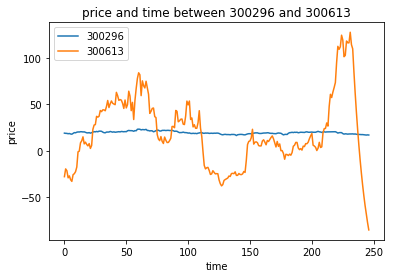

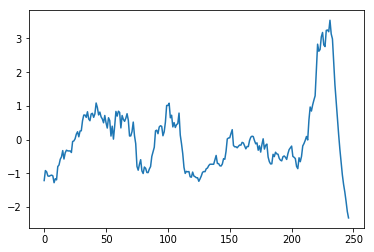

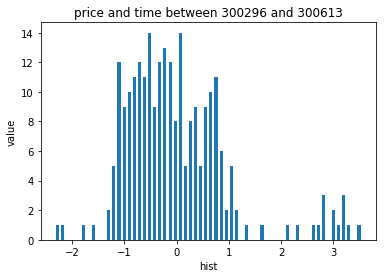

xcode:300296, ycode:300613, mean:-0.28215044144209567, std:34.73914480104272, beta:[9.486400802872057]


得到的数据如，可以看出价格差的大小在区间内变化。可以取出合适的阈值为

xcode的入场信号：score > 1
ycode的入场信号：score < -1.1
所有股票离场信号：score > -0.9 and score < 0.8
价差序列的beta为：9.486
价差序列的std为：34.739
价差序列的均值为：-0.282

接下来使用pyalgotrade来进行回测和结果分析。
由于前面的分析，我们知道，配对交易的模型适合震荡市中。当市场的系统性风险过大的时候，就会导致该模型失效。

所以在测试前，我们的预计在震荡市中该算法的效果很好。但是在单边市的效果很差。
对于整个半导体板块，我们可以看到
在”20180215“-“20190610”之间是一个震荡市区间
在“20180610“-”20181030”之间是一个单边下跌区间。
所以我们预期：
在震荡市区间表现较好，而在单边下跌区间会止损出局。
使用pyalgotrade可以设置不同的数据区间进行测试。
这里使用onBars函数来进行回测。列出执行的条件。

In [18]:
    def onBars(self, bars):
        #总离场信号：买入后亏损达到10%后，立刻无脑止损
        if self.__cash / self.getBroker().getCash() < 0.9:
            if x_share > 0: self.__position = self.enterShort(self.__codex, x_share, True)
            if y_share > 0: self.__position = self.enterShort(self.__codey, y_share, True)
            return

        x_price   = bars[self.__codex].getClose()
        x_share   = self.getBroker().getShares(self.__codex)
        x_extra   = bars[self.__codex].getExtraColumns()
        x_pchange = x_extra['pchange']

        y_price   = bars[self.__codey].getClose()
        y_share   = self.getBroker().getShares(self.__codey)
        y_extra   = bars[self.__codey].getExtraColumns()
        y_pchange = y_extra['pchange']

        spread = y_price - x_price * self.__beta
        score = (spread - self.__mean)/self.__std
        #X入场信号
        if score > 1 and x_share == 0:
            if y_share > 0: self.__position = self.enterShort(self.__codey, y_share, True)
            shares = 100 * int((self.getBroker().getCash()/(100 * x_price)) - 1)
            if shares > 0: self.__position = self.enterLong(self.__codex, shares, True)

        #Y入场信号
        if score < -1.1 and y_share == 0:
            if x_share > 0: self.__position = self.enterShort(self.__codex, x_share, True)
            shares = 100 * int((self.getBroker().getCash()/(100 * y_price) - 1))
            if shares > 0: self.__position = self.enterLong(self.__codey, shares, True)

        #所有股票离场信号
        if score < 0.8 and score > -0.9:
            if x_share > 0: self.__position = self.enterShort(self.__codex, x_share, True)
            if y_share > 0: self.__position = self.enterShort(self.__codey, y_share, True)

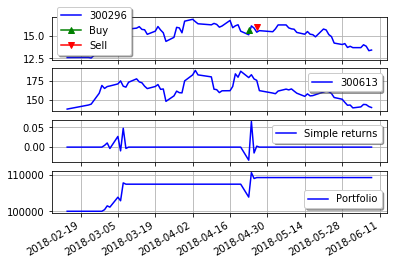

In [24]:
以下是在震荡区间使用配对交易得到的结果。满足盈利的输出，初始资金为100000元。

Final portfolio value: $109246.42
Cumulative returns: 9.25 %
Sharpe ratio: 1.54
Max. drawdown: 3.62 %
Longest drawdown duration: 47 days, 0:00:00
Final portfolio value: $109246.42

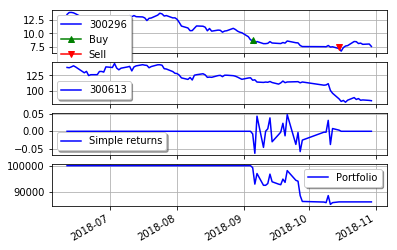

2018-11-05 12:48:08,233 strategy [INFO] Final portfolio value: $86073.88
2018-11-05 12:48:08,245 strategy [INFO] Cumulative returns: -13.93 %
2018-11-05 12:48:08,251 strategy [INFO] Sharpe ratio: -1.73
2018-11-05 12:48:08,280 strategy [INFO] Max. drawdown: 14.89 %
2018-11-05 12:48:08,292 strategy [INFO] Longest drawdown duration: 56 days, 0:00:00


In [27]:
以下是在单边区间使用配对交易得到的结果。满足盈利的输出，初始资金为100000元。
Final portfolio value: $86073.88
Cumulative returns: -13.93 %
Sharpe ratio: -1.73
Max. drawdown: 14.89 %
Longest drawdown duration: 56 days, 0:00:00

In [ ]:
总结：该配对交易在实际中是有难点的。
1、股票的协整关系的选取区间。
2、震荡市的判断。
3、阈值的选取这里还是根据历史信息来获取的，不一定准确。
4、使用该策略一定需要设置强制止损。